<h2>Titanic Survival Prediction</h2>

We will be working on the famous Titanic data set. The goal will be to predict survival given a few factors describing each passenger. We will evaluate the created model using accuracy as a metric.

In [934]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import scipy.stats
from sklearn.svm import SVR,SVC
from sklearn.ensemble import RandomForestRegressor,VotingClassifier,GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import SGDRegressor,LogisticRegression
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.cluster import DBSCAN
from sklearn.naive_bayes import GaussianNB,MultinomialNB
import warnings
warnings.filterwarnings('ignore')

In [935]:
# Read in respective data sets.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [936]:
# Observe for any missing data or incorrect data types.
print(train.info(),test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In the training set, we have missing values in the Age, Cabin, and Embarked features while the test set is missing values in the Age, Fare, and Cabin features. 

We begin by dropping features that seem irrelevant to the prediction of survival.

In [937]:
train=train.drop(columns=['PassengerId','Ticket','Cabin'])
test=test.drop(columns=['PassengerId','Ticket','Cabin'])

We bin the ages of each passenger in intervals of 10.

In [938]:
train['age_binned'] = pd.cut(train['Age'], bins=[i*10 for i in range(8)])

An interesting thing to note is that women in Pclass 3 are the only group that has an exact 50/50 chance of survival. All other combinations of class and sex result in a solid disparity in the probability of survival.

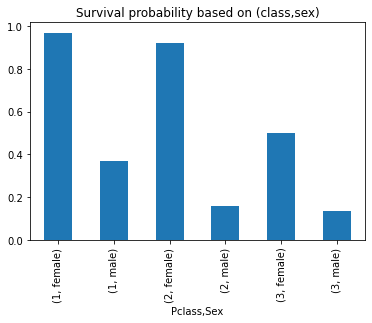

In [939]:
s_SexPclass = train.groupby(['Pclass','Sex'])['Survived'].mean()
s_SexPclass.plot.bar(title='Survival probability based on (class,sex)')

In [940]:
s_class = train.groupby(['Pclass'])['Survived'].mean()
s_sex = train.groupby('Sex')['Survived'].mean()
s_Age = train.groupby('age_binned')['Survived'].mean()

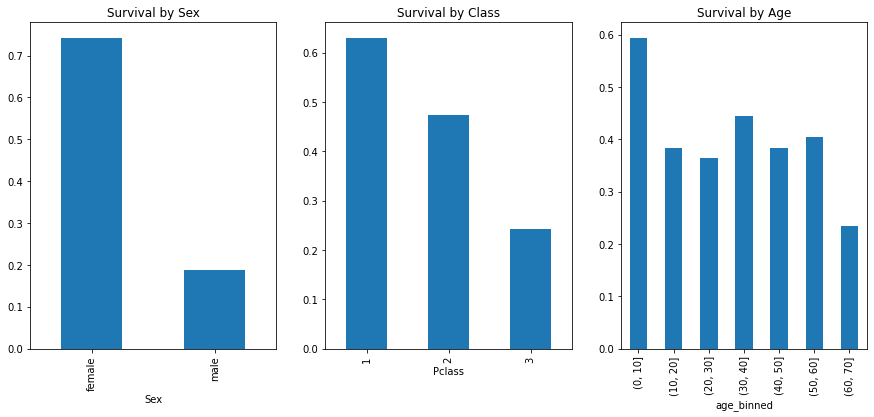

In [941]:
fig, (a1,a2,a3) = plt.subplots(1, 3, figsize=(15,6))

ax = s_sex.plot.bar(ax=a1, title='Survival by Sex')
ax = s_class.plot.bar(ax=a2, title='Survival by Class')
ax = s_Age.plot.bar(ax=a3, title='Survival by Age')


Clear disparity in survival based off sex and class. With age it's not surprising to see young children with the highest survival rate. With regards to sex, do note that the number of men far exceeds the number of women aboard the ship.

<h2>Feature Engineering</h2>

Define a feature to label the title of each passenger.

In [942]:
def title(s):
    # use regex to isolate string after first comma and before first period
    final = re.findall(r'\, (.*?)\..*', s)
    return(final[0])

In [943]:
# create new column for title in dataframe
train['Title'] = train['Name'].apply(title)

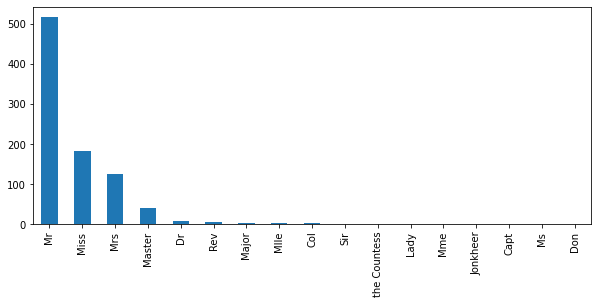

In [944]:
# Check distribution of different titles
plt.figure(figsize=(10,4))
train.Title.value_counts().plot(kind='bar')
plt.show()

Let's try to minimize the number of titles. Mlle,Ms, Mme, Countess will be mapped to Miss. Don, Jonkheer, and Sir will be mapped to Mr. Major, Capt, Col will be mapped to the title of Military.

In [945]:
def min_titles(t):
    if t in ['Mlle','Ms', 'Mme', 'the Countess','Dona']:
        res = 'Miss'
    elif t in ['Don', 'Jonkheer','Sir']:
        res = 'Mr'
    elif t in ['Major','Capt', 'Col']:
        res = 'Military'
    elif t in ['Lady']:
        res = 'Mrs'
    else:
        res = t
    return(res)

In [946]:
train['Title'] = train['Title'].apply(min_titles)

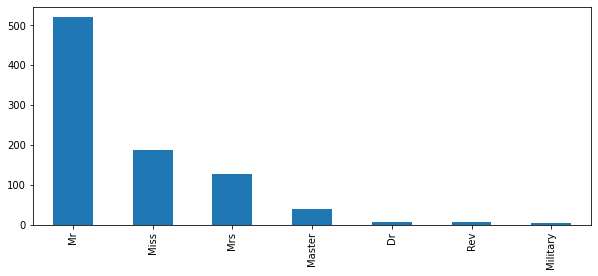

In [947]:
plt.figure(figsize=(10,4))
train.Title.value_counts().plot(kind='bar')
plt.show()

This looks much better and concise.

We now fill in the missing values for the Embarked feature though it is not likely that it offers much boost to predictability.

In [948]:
# Obtain passengers with missing embarked location.
train.loc[train['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,age_binned,Title
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN,"(30, 40]",Miss
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN,"(60, 70]",Mrs


In [949]:
# Group by the passenger class and age bin to find mode of embarked location.
train.groupby(['Pclass','age_binned'])['Embarked'].apply(pd.Series.mode)

Pclass  age_binned   
1       (0, 10]     0    S
        (10, 20]    0    S
        (20, 30]    0    C
        (30, 40]    0    S
        (40, 50]    0    S
        (50, 60]    0    S
        (60, 70]    0    S
2       (0, 10]     0    S
        (10, 20]    0    S
        (20, 30]    0    S
        (30, 40]    0    S
        (40, 50]    0    S
        (50, 60]    0    S
        (60, 70]    0    S
3       (0, 10]     0    S
        (10, 20]    0    S
        (20, 30]    0    S
        (30, 40]    0    S
        (40, 50]    0    S
        (50, 60]    0    S
        (60, 70]    0    S
Name: Embarked, dtype: object

Hence, both missing values for embarked will be filled with Soutampton(S)

In [950]:
train['Embarked']=train['Embarked'].fillna('S')

Working with age, we will groupby several features and impute with the median in each group.

In [951]:
train['Age'] = train.groupby(['Title','SibSp'])['Age'].transform(lambda x:x.fillna(x.median()))


In [952]:
# Check for any remaining missing age values.
train[train['Age'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,age_binned,Title
159,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,69.55,S,NaN,Master
180,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,69.55,S,NaN,Miss
201,0,3,"Sage, Mr. Frederick",male,NaN,8,2,69.55,S,NaN,Mr
324,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,69.55,S,NaN,Mr
792,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,69.55,S,NaN,Miss
846,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,69.55,S,NaN,Mr
863,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,69.55,S,NaN,Miss


The remaining missing values for age come from the single family of 8. We will fill in it with just the median for each title.

In [953]:
train['Age'] = train.groupby(['Title'])['Age'].transform(lambda x:x.fillna(x.median()))

We combine the two sets now to fill in the missing values for the test set.

In [954]:
# set aside the survival feature of the train set
trainY = train[['Survived']]
train = train.drop(['Survived'],axis=1)

In [955]:
test['Title'] = test['Name'].apply(title)
test['Title'] = test['Title'].apply(min_titles)
test['age_binned'] = pd.cut(test['Age'], bins=[i*10 for i in range(8)])

In [956]:
# combine the train and test set
full = pd.concat([train,test])

In [957]:
full = full.reset_index().drop(['index'],axis=1)

There is a single missing value in the fare column. We fill it with the median price for Pclass 3.

In [958]:
full.loc[full['Fare'].isnull()]

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Title,age_binned
1043,60.5,S,NaN,"Storey, Mr. Thomas",0,3,male,0,Mr,"(60, 70]"


In [959]:
full['Fare'] = full.groupby(['Pclass'])['Fare'].transform(lambda x:x.fillna(x.median()))

<h5>Fill missing age values in test set.</h5>

We will now build a model to predict the missing age values.

Need to obtain the min and max values to apply MinMaxScaler to numerical variables.

In [960]:
# Get min/max values for fare and age in order to apply min/max scaler for 
# final prediction of survival.
maxFare=full['Fare'].max()
minFare=full['Fare'].min()
maxAge = full['Age'].max()
minAge = full['Age'].min()

In [961]:
full = full.drop(['age_binned','Name'],axis=1) 

In [962]:
# Convert categorical variables to dummy variables
full = pd.get_dummies(data=full, columns=['Pclass', 'Sex','Embarked','Title'])

In [963]:
# Standardize fare feature with MinMaxScaler
full['Fare']-=minFare
full['Fare']/=(maxFare-minFare)

In [964]:
# Isolate passengers for which age is not empty.
fullTrain = full.loc[full['Age'].notna()]

In [965]:
# Separate age to be used as prediction.
age = fullTrain['Age']
fullTrain = fullTrain.drop(['Age'],axis=1)

In [966]:
# Set model
model = RandomForestRegressor(n_estimators=100,max_features= 'log2',bootstrap=True,
                               random_state=42,max_depth=10) 

# Use 3-fold cross validation to measure performance.
scores = cross_val_score(model,fullTrain,age,scoring='neg_mean_squared_error',cv=3)

In [967]:
# Find median error score using the chosen model
med = np.median(np.sqrt(-1*scores))

In [968]:
print("68%% of predicted ages will fall within %.2f years of actual age." %(round(med,2)))

68% of predicted ages will fall within 10.11 years of actual age.


In [969]:
# Fit model
model.fit(fullTrain,age)

RandomForestRegressor(max_depth=10, max_features='log2', random_state=42)

In [970]:
# Fill missing age values from test set.
fullTest = full.loc[full['Age'].isnull()].drop(['Age'],axis=1)
predAge = model.predict(fullTest)
full.loc[full['Age'].isna(), 'Age'] = predAge

In [971]:
# Apply MinMaxScaler to age feature.
full['Age']-=minAge
full['Age']/=(maxAge-minAge)

We introduce 3 functions to indicate a wealthy woman, an older man, and a young female in class 3.

In [972]:
def wealthyWoman(s,f):
    if (s==1 and f>0):
        return(1)
    else:
        return(0)

In [973]:
def olderMan(a,m):
    if (a>1 and m==1):
        return(1)
    else:
        return(0)

In [974]:
def poor_YoungWoman(a,f,c3):
    if (0.20 <= round(a,2) <= .51) & (c3==1) & (f==1):
        return(1)
    else:
        return(0)

Apply the created functions to the dataset.

In [975]:
full['richWoman'] = full.apply(lambda x: wealthyWoman(x.Sex_female, x.Fare), axis=1)

In [976]:
full['oldMan'] = full.apply(lambda x: olderMan(x.Age, x.Sex_male), axis=1)

In [977]:
full['poorYoungWoman'] = full.apply(lambda x: poor_YoungWoman(x.Age,x.Pclass_3,x.Sex_female),axis=1)

We can now begin predictions on survival.

In [978]:
# There were 891 passengers in the training set so we separate the full set accordingly.
trainX,testX = full[:891],full[891:]

In [979]:
cols = trainX.columns

In [980]:
# Isolate only numeric features to perform DBSCAN clustering and remove potential outliers.
trainXnum = trainX[cols[0:2]]

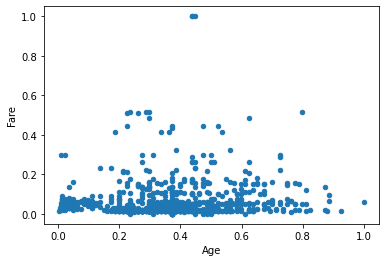

In [981]:
trainXnum.plot.scatter(x = "Age", y = "Fare")

A group of outliers do appear around an age value of .5 with the max fare value.

In [982]:
db = DBSCAN(eps = 0.5, metric="manhattan",min_samples = 3)
clust = db.fit_predict(trainXnum)

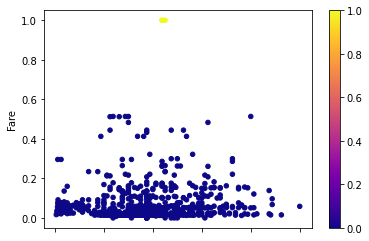

In [983]:
trainXnum.plot.scatter(x = "Age",y = "Fare",c = clust, cmap = 'plasma')

In [984]:
# Find index value of clusters and remove them from the dataset prior to training.
np.where(clust==1)
trainX = trainX.drop(trainX.index[[258,679,737]])
trainY = np.asarray(trainY).ravel()
trainY = np.delete(trainY, [258,679,737])

In [985]:
# Attempt different models.
m1 = RandomForestClassifier(n_estimators=135,max_depth=15,max_features=None,min_samples_split=15,random_state=42)
m2 = GradientBoostingClassifier(n_estimators=500,max_depth=2,learning_rate = .05,subsample=.95,random_state=42)
m3 = KNeighborsClassifier(n_neighbors=13,metric='minkowski',p=1)
m4 = SVC(C=1,class_weight=None,gamma='auto',probability=True,random_state=42)
m5 = LogisticRegression(C=1,penalty='l2')


In [986]:
# Utilize 3-fold cross-validation to output assess accuracy scores.
scores = cross_val_score(m1,trainX,trainY,scoring='accuracy',cv=3)
print(scores)

[0.81756757 0.88513514 0.84797297]


In [987]:
# Fit chosen models.
m1.fit(trainX,trainY)
m4.fit(trainX,trainY)

SVC(C=1, gamma='auto', probability=True, random_state=42)

In [988]:
resR = m1.predict_proba(testX)
resSV = m4.predict_proba(testX)

In [989]:
res = pd.DataFrame({"sv":resSV[:,1], "rf":resR[:,1],
                   "svBin":(resSV[:,1]>.5)*1, "rfBin":(resR[:,1]>.5)*1})

We will find instances in the test set with females in class 3. As we saw from the train set, these passengers were 50/50 with regards to survival so we make the threshold for them higher. We will require at least one of the models predict a probability of over .75 to say the particular passenger survived.

In [990]:
j = res.iloc[test.loc[(test['Pclass']==3) & (test['Sex']=='female')].index.values]
j_ind = j.index.values

In [991]:
# Mark these indices as survived
v = (j.loc[(j['sv']>.75) | (j['rf']>.75)]).index.values

In [992]:
# Mark these as died
rem = np.asarray(list(set(j_ind)^set(v)))

In [993]:
# Take average probability of two columns and set threshold for survival at .65.
res['surv'] = (((res['sv'] + res['rf'])/2)>.65)*1

In [994]:
# Set response for females in class 3.
res.loc[v,'surv'] = 1 
res.loc[rem,'surv'] = 0

In [995]:
results1=pd.DataFrame({"PassengerId":[i for i in range(892,1310)],
                  "Survived":np.array(res['surv']).reshape(418,)})

Form csv with survival predictions.

In [900]:
# results1.to_csv('res.csv',index=False)